# Sixth Exercise (HPO)

This exercise focuses on hyperparameter optimization with neural networks.

We will
- define hyperparameter-configuration search-spaces
- train deep learning models with various hyper parameters
- use random search as a basic hyperparameter optimizer
- use BOHB as an advanced hyperparameter optimizer

It's in the nature of hyperparameter optimization, that you'll have to train a lot of models. 
Therefore execution time will be longer in this exercise, running the completed notebook takes about 30 minutes on a tutor's 3 year old laptop.

#### Install HpBandster and torchvision

You need to install two more python packages for this exercise.

- [torchvision](https://pytorch.org/docs/stable/torchvision/) provides utility methods for pytorch.
- [HpBandSter](https://github.com/automl/HpBandSter) is a fast, parallel implementation of several hyperparameter optimizers.  
   We can define even complex hyperparameter search spaces with [ConfigSpace](https://github.com/automl/ConfigSpace), which comes along HpBandSter as dependency.


Install with anaconda/conda
```
conda install torchvision
conda install hpbandster
```

or with plain python
```
pip3 install torchvision
pip3 install hpbandster
```

In [1]:
import os
from typing import Tuple, List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
import torchvision.transforms as transforms

import ConfigSpace as CS
import ConfigSpace.hyperparameters as CSH

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


def load_mnist_minibatched(batch_size: int, n_train: int = 8192, n_valid: int = 1024,
                           valid_test_batch_size: int = 1024) -> Tuple[DataLoader, DataLoader, DataLoader]:
    train_dataset = torchvision.datasets.MNIST(
        root='../data', train=True, transform=transforms.ToTensor(), download=True)
    test_dataset = torchvision.datasets.MNIST(
        root='../data', train=False, transform=transforms.ToTensor())

    train_sampler = SubsetRandomSampler(range(n_train))
    validation_sampler = SubsetRandomSampler(range(n_train, n_train+n_valid))

    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, sampler=train_sampler)
    validation_loader = DataLoader(dataset=train_dataset, batch_size=valid_test_batch_size,
                                   sampler=validation_sampler)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=valid_test_batch_size, 
                                              shuffle=False)
    return train_loader, validation_loader, test_loader


def evaluate_accuracy(model: nn.Module, data_loader: DataLoader) -> float:
    model.eval()
    correct = 0
    with torch.no_grad():
        for x, y in data_loader:
            if torch.cuda.is_available(): # TODO
                x, y = x.cuda(), y.cuda()
            output = model(x)
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(y.view_as(pred)).sum().item()
    accuracy = correct / len(data_loader.sampler)
    return(accuracy)

## Random Search

Here we get hands on hyperparameter optimization using random search.

### Model and Hyperparameter Space

First we define a configurable model and a hyperparameter space. You learn how to use *ConfigSpace* to define the hyperparameters, by looking at [this example](https://automl.github.io/SMAC3/stable/quickstart.html#using-smac-in-python-svm).   

**Task:** Complete the functions as described in the docstrings.

**Hint:** The `CS.GreaterThanCondition(conditioned_hyperparameter, lefthand_side, righthand_side)` method might be useful.

In [2]:
from collections import OrderedDict
    
def get_conv_model(num_filters_per_layer: List[int]) -> nn.Module:
    """Builds a deep convolutional model with various number of convolution
       layers for MNIST input using pytorch.
    
    for each element in num_filters_per_layer:
        convolution (conv_kernel_size, num_filters, stride=1, padding=0)
        relu
        max pool    (pool_kernel_size, stride=None)
    linear
    log softmax
    """
    assert len(num_filters_per_layer) > 0, "len(num_filters_per_layer) should be greater than 0"
    pool_kernel_size = 2
    conv_kernel_size = 3
    
    # START TODO ################
    class Flatten(nn.Module):
        def forward(self, x):
            flattened = x.view(x.size(0), -1)
            return flattened
    
    layers = []
    size = 28
    num_filters_prev = 1
    for num_filters in num_filters_per_layer:
        layers.append(nn.Conv2d(
                in_channels=num_filters_prev,
                out_channels=num_filters,
                kernel_size=conv_kernel_size,
                stride=1,
                padding=0
            )
        )
        layers.append(nn.ReLU(inplace=True))
        layers.append(nn.MaxPool2d(
                kernel_size=pool_kernel_size,
                stride=None
            )
        )
        num_filters_prev = num_filters
        size = (size - conv_kernel_size + 1) // pool_kernel_size
    
    flattened_size = size * size * num_filters_prev
    layers.append(Flatten())
    layers.append(nn.Linear(flattened_size, 10))
    layers.append(nn.LogSoftmax(dim=1))
    model = nn.Sequential(*layers)
    return model
    # End TODO ################


def get_configspace() -> CS.ConfigurationSpace:
    """ Define a conditional hyperparameter search-space.
    
    hyperparameters:
      lr              from 1e-6 to 1e-0 (log, float)
      num_filters_1   from    2 to    8 (int)
      num_filters_2   from    2 to    8 (int)
      num_conv_layers from    1 to    2 (int)
    
    conditions: 
      include num_filters_2 only if num_conv_layers > 1
    """
    cs = CS.ConfigurationSpace()
    # START TODO ################

    # Hyperparameters
    lr = CSH.UniformFloatHyperparameter(
        "lr",
        lower=1e-6, upper=1,
        log=True
    )
    num_filters_1 = CSH.UniformIntegerHyperparameter(
        "num_filters_1",
        lower=2, upper=8
    )
    num_filters_2 = CSH.UniformIntegerHyperparameter(
        "num_filters_2",
        lower=2, upper=8
    )
    num_conv_layers = CSH.UniformIntegerHyperparameter(
        "num_conv_layers",
        lower=1, upper=2
    )
    cs.add_hyperparameters([
        lr, num_filters_1,
        num_filters_2,
        num_conv_layers
    ])

    # Conditions
    include_num_filters_2 = CS.InCondition(
        child=num_filters_2,
        parent=num_conv_layers,
        values=[2]
    )
    cs.add_condition(include_num_filters_2)
    
    # End TODO ################
    return cs

### Run model with configuration

A single sample from your hyperparameter space is a *Configuration*. You can use the configuration similar to a dictionary, it supports *config.keys(), config.values(), value = config[key], key in config, …* .
You can iterate a *DataLoader* to access (data, label) batches.

**Note:** If a condition isn't met, the conditional hyperparameter isn't included in the configuration.

**Task:** Complete the function to run a model like defined by the configuration. The function should return the model and the *validation error* for each epoch. You can use *evaluate_accuracy* (defined above), don't forget to switch between train and eval mode.

In [3]:
def run_conv_model(config: CS.Configuration, epochs: int, train_loader: DataLoader,
                   validation_loader: DataLoader) -> Tuple[nn.Module, List[float]]:    
    """ Run and evaluate a model from get_conv_model with NLLLoss and SGD.
    """
    # START TODO ################
    # retrieve the number of filters from the config and create the model
    num_filters = [config["num_filters_1"]]
    if config["num_conv_layers"] >= 2:
        num_filters.append(config["num_filters_2"])
    if config["num_conv_layers"] == 3:
        num_filters.append(config["num_filters_3"])

    model = get_conv_model(num_filters)
    if torch.cuda.is_available(): # TODO
        model.cuda()
    # define loss and optimizer
    loss_fn = nn.NLLLoss()
    if "optimizer" in config:
        if config["optimizer"] == "Adam":
            optimizer = torch.optim.Adam(lr=config["lr"], params=model.parameters())
        if config["optimizer"] == "SGD":
            momentum = 0
            if "sgd_momentum" in config:
                momentum = config["sgd_momentum"]
            optimizer = torch.optim.SGD(lr=config["lr"], momentum=momentum, params=model.parameters())
    else:
        optimizer = torch.optim.SGD(lr=config["lr"], params=model.parameters())

    # train the model for `epochs` and save the validation error for each epoch in
    val_errors = []
    for _ in range(epochs):
        
        # Train
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            images, labels = batch
            if torch.cuda.is_available(): # TODO
                images, labels = images.cuda(), labels.cuda()
            predictions = model(images)
            loss = loss_fn(predictions, labels)
            loss.backward()
            optimizer.step()
            
        # Evaluate
        val_errors.append(1 - evaluate_accuracy(data_loader=validation_loader, model=model))

    # End TODO ################
    return model, val_errors

Now let's run models with various, random hyperparameter configurations. Don't forget to store all the configuration and validation errors for further evaluation.

**Tipp:** *ConfigSpace* objects have a *.sample_configuration()* function to sample a random configuration.

**Task:** Run *n_random_samples* models for *n_epochs* and store the tuple `(model, config, val_errors)` in `results`.

In [4]:
n_random_samples = 18
n_epochs = 9
cs = get_configspace()
train_loader, validation_loader, _ = load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

# START TODO ################
results = []

for idx in range(n_random_samples):
    print(f"Sample configuration {idx + 1} / {n_random_samples}")
    config = cs.sample_configuration()
    model, val_errors = run_conv_model(
        config=config,
        epochs=n_epochs,
        train_loader=train_loader,
        validation_loader=validation_loader
    )
    results.append((model, config, val_errors))
# End TODO ################

Sample configuration 1 / 18
Sample configuration 2 / 18
Sample configuration 3 / 18
Sample configuration 4 / 18
Sample configuration 5 / 18
Sample configuration 6 / 18
Sample configuration 7 / 18
Sample configuration 8 / 18
Sample configuration 9 / 18
Sample configuration 10 / 18
Sample configuration 11 / 18
Sample configuration 12 / 18
Sample configuration 13 / 18
Sample configuration 14 / 18
Sample configuration 15 / 18
Sample configuration 16 / 18
Sample configuration 17 / 18
Sample configuration 18 / 18


### Evaluate 

Now we should evaluate the previous runs. Evaluation in hyperparameter optimization can mean two different things: On the one hand, we might be only interested in the model with the best performance. On the other hand, we might want to find the best hyperparameter configuration to then train a model with these hyper-parameters (but with e.g. more epochs).

**Task:** Print the model and final validation error of the best model in `results`.

In [5]:
# START TODO ################
best_result = sorted(results, key=lambda result: result[2][-1])[0]
print("Model:")
print(best_result[0])
print(best_result[1])
print("Error rate:")
print(best_result[2][-1])
# END TODO ################

Model:
Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=200, out_features=10, bias=True)
  (8): LogSoftmax()
)
Configuration:
  lr, Value: 0.16081890389792003
  num_conv_layers, Value: 2
  num_filters_1, Value: 4
  num_filters_2, Value: 8

Error rate:
0.03515625


Let's further investigate which hyperparameters work well and which don't.

**Task:** Print a scatter plot of learning rate (x) and number of filters (sum over layers, y). Scale the size of the scatter points by the error in the last epoch (10 to 100).

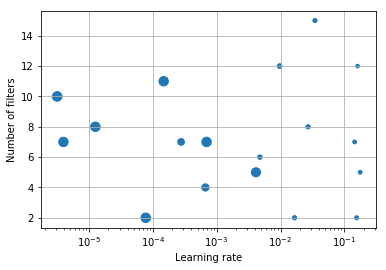

In [6]:
# START TODO ################
models, configs, val_errorss = zip(*results)
learning_rates = list(map(lambda c: c["lr"], configs))

num_filters = list(map(lambda c: c["num_filters_1"] + (c["num_filters_2"] if "num_filters_2" in c else 0), configs))

size_min, size_max = 10, 100
point_sizes = list(map(lambda val_errors: val_errors[-1] * (size_max - size_min) + size_min, val_errorss))

plt.figure()
plt.xscale("log")
plt.grid(True)
plt.xlabel("Learning rate")
plt.ylabel("Number of filters")
plt.scatter(learning_rates, num_filters, s=point_sizes)
pass
# END TODO ################

**Question:** What pattern do you see? Why might it occur?

**Answer:**  
The pattern that occurs confirms that the learning rate is one of, if not, the most important hyperparameter in deep learning. The loss is high if the learning rate is set too low or too high, independently of the number of convolutional filters. Learning rate's sweet spot is roughly between $ 10^{-2} $ and $ 10^{-1} $.

That happens because if the learning rate is too small, we get a slow convergence to a (local) optimum and we need more epochs. On the other hand, if the learning rate is too big, we have big jumps around the local optima and sometimes we do not even converge.

In this case, the range of a total number of convolutional filters does not seem to play a significant role in the loss value.

After looking at the final error, let's now have a look at the training error.

**Task:** Plot error curves (error per epoch) for all your configurations in one figure.

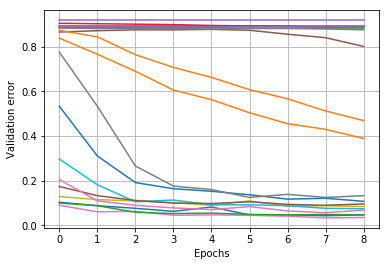

In [7]:
# START TODO ################
epochs = range(len(val_errorss[0]))
plt.figure()
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("Validation error")
for val_errors in val_errorss:
    plt.plot(epochs, val_errors)

# END TODO ################

**Questions:** How could you detect configurations with a low error earlier/faster? Why could this be problematic? 

**Answers:**  
We could assume that configurations for which validation loss is decreasing faster, or starts at a lower value, are better. This assumption can be problematic because worse configurations from the beginning may perform better than the selected ones in the long run.

### Your Feedback on Exercise 6.1

- Time spent: 1.5 - 2 h
- Useful: yes; getting to know how ConfigSpace works
- Major problems: none

This part of the exercise is pretty much straightforward. Our experience with ConfigSpace from Machine Learning course was very useful and the exercise refreshed some working concepts of it.

## BOHB

Here we will use the more advanced hyperparameter optimizer [BOHB](https://www.automl.org/blog_bohb/) (Bayesian Optimization with Hyperband).
Based on [Hyperband](https://arxiv.org/pdf/1603.06560.pdf), BOHB evaluates configurations on your model with increasing budgets. In the context of Deep Learning, budget can be the number of epochs or the number of training samples. In lower budget evaluations, BOHB can look at more configurations. Full budget evaluations avoid missing configurations which are poor at the beginnning but good at the end (and vice versa). 
At the start of a run, BOHB samples configurations randomly. After some time, BOHB then uses a bayesian model (based on Parzen Tree Estimators), sampling only promising configs.

This exercise part is based on the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html) and the [HpBandSter Documentation](https://automl.github.io/HpBandSter/). *HpBandSter* provides a fast implementation of *Randomsearch*, *Hyperband* and *BOHB*. The optimization can easily be distributed between multiple cores or even multiple computers.

In [8]:
import pickle
import logging

from hpbandster.core.worker import Worker
import hpbandster.core.nameserver as hpns
import hpbandster.core.result as hpres
from hpbandster.optimizers import BOHB

logging.getLogger('hpbandster').setLevel(logging.DEBUG)

/home/borna/opt/anaconda3/envs/dl4ad/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Implement Worker

The worker defines the hyperparameter problem which we try to optimize.
*compute(...)* should - for a given configuration and budget - return a loss which the hyperparameter optimizer tries to minimize. In our case, we can use the number of epochs as budget and the validation error as loss. 
As best practice, we define the configuration space also in the worker.

If you need help, you might get some inspiration from the [HpBandSter Pytorch Worker Example](https://automl.github.io/HpBandSter/build/html/auto_examples/example_5_pytorch_worker.html#sphx-glr-auto-examples-example-5-pytorch-worker-py).

**Task:** Complete the methods below.

In [9]:
class PyTorchWorker(Worker):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.train_loader, self.validation_loader, self.test_loader =\
            load_mnist_minibatched(batch_size=32, n_train=4096, n_valid=512)

    @staticmethod
    def get_model(config: CS.Configuration) -> nn.Module:
        """ Define a configurable convolution model.
            
        See description of get_conv_model above for more details on the model.
        """
        # START TODO ################
        num_filters = [config["num_filters_1"]]
        if config["num_conv_layers"] > 1:
            num_filters.append(config["num_filters_2"])

        model = get_conv_model(num_filters)
        return model
        # END TODO ################
        
    @staticmethod
    def get_configspace() -> CS.Configuration:
        """ Define a conditional hyperparameter search-space.
    
        hyperparameters:
          num_filters_1   from    4 to   32 (int)
          num_filters_2   from    4 to   32 (int)
          num_filters_3   from    4 to   32 (int)
          num_conv_layers from    1 to    3 (int)
          lr              from 1e-6 to 1e-1 (float, log)
          sgd_momentum    from 0.00 to 0.99 (float)
          optimizer            Adam or  SGD (categoric)
          
        conditions: 
          include num_filters_2 only if num_conv_layers > 1
          include num_filters_3 only if num_conv_layers > 2
          include sgd_momentum  only if       optimizer = SGD
        """
        # START TODO ################
        cs = CS.ConfigurationSpace()
        # Hyperparameters
        lr = CSH.UniformFloatHyperparameter(
            "lr",
            lower=1e-6, upper=1e-1,
            log=True
        )
        sgd_momentum = CSH.UniformFloatHyperparameter(
            "sgd_momentum",
            lower=0.00, upper=0.99
        )
        num_filters_1 = CSH.UniformIntegerHyperparameter(
            "num_filters_1",
            lower=4, upper=32
        )
        num_filters_2 = CSH.UniformIntegerHyperparameter(
            "num_filters_2",
            lower=4, upper=32
        )
        num_filters_3 = CSH.UniformIntegerHyperparameter(
            "num_filters_3",
            lower=4, upper=32
        )
        num_conv_layers = CSH.UniformIntegerHyperparameter(
            "num_conv_layers",
            lower=1, upper=3
        )
        optimizer = CSH.CategoricalHyperparameter(
            "optimizer",
            ["SGD", "Adam"]
        )
        cs.add_hyperparameters([
            lr,
            num_filters_1,
            num_filters_2,
            num_filters_3,
            num_conv_layers,
            optimizer,
            sgd_momentum
        ])

        # Conditions
        include_num_filters_2 = CS.InCondition(
            child=num_filters_2,
            parent=num_conv_layers,
            values=[2, 3]
        )
        include_num_filters_3 = CS.InCondition(
            child=num_filters_3,
            parent=num_conv_layers,
            values=[3]
        )
        include_sgd_momentum = CS.InCondition(
            child=sgd_momentum,
            parent=optimizer,
            values=["SGD"]
        )
        cs.add_conditions([
            include_num_filters_2,
            include_num_filters_3,
            include_sgd_momentum
        ])

        return cs
        # END TODO ################

    def compute(self, config: CS.Configuration, budget: float, working_directory: str,
                *args, **kwargs) -> float:
        """Evaluate a function with the given config and budget and return a loss.
        
        Bohb tries to minimize the returned loss.
        
        In our case the function is the training and validation of a model,
        the budget is the number of epochs and the loss is the validation error.
        """
        model = self.get_model(config)
        
        # START TODO ################
        model, _ = run_conv_model(
            config=config,
            epochs=int(budget),
            train_loader=self.train_loader,
            validation_loader=self.validation_loader
        )
        # END TODO ################
        
        train_accuracy = evaluate_accuracy(model, self.train_loader)
        validation_accuracy = evaluate_accuracy(model, self.validation_loader)
        test_accuracy = evaluate_accuracy(model, self.test_loader)
        
        return ({
                'loss': 1 - validation_accuracy,  # remember: HpBandSter minimizes the loss!
                'info': {'test_accuracy': test_accuracy,
                         'train_accuracy': train_accuracy,
                         'valid_accuracy': validation_accuracy,
                         'model': str(model)}
                })

   

It's best practice to do a quick sanity check of our worker with a low budget:

In [10]:
working_dir = os.curdir
# minimum budget that BOHB uses
min_budget = 1
# largest budget BOHB will use
max_budget = 9

In [11]:
worker = PyTorchWorker(run_id='0')
cs = worker.get_configspace()

config = cs.sample_configuration().get_dictionary()
print(config)

res = worker.compute(config=config, budget=min_budget, working_directory=working_dir)
print(res)

{'lr': 0.04618610473126494, 'num_conv_layers': 3, 'num_filters_1': 12, 'optimizer': 'SGD', 'num_filters_2': 24, 'num_filters_3': 21, 'sgd_momentum': 0.3721257868423284}
{'loss': 0.615234375, 'info': {'test_accuracy': 0.3909, 'train_accuracy': 0.373779296875, 'valid_accuracy': 0.384765625, 'model': 'Sequential(\n  (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1))\n  (1): ReLU(inplace)\n  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1))\n  (4): ReLU(inplace)\n  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (6): Conv2d(24, 21, kernel_size=(3, 3), stride=(1, 1))\n  (7): ReLU(inplace)\n  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (9): Flatten()\n  (10): Linear(in_features=21, out_features=10, bias=True)\n  (11): LogSoftmax()\n)'}}


### Run BOHB

We now run the hyperparameter search with BOHB and the worker which we defined above and save the result to disk. 
Try to understand what happens. *HpBandSter* allows to start additional workers on the same or remote devices to parallelize the executions, that's why we need to setup some network stuff (nameserver, nic, host, port, …). If you're interested, you can check this out in the [HpBandSter Examples](https://automl.github.io/HpBandSter/build/html/auto_examples/index.html), but it is beyond the scope of this exercise.

**Note:** The code below will try 60 different configurations. Some of them are executed at multiple budgets, which results in about 80 model training. Therefore it might take a while (15-45 minutes on a laptop). If you are interested in how BOHB works, checkout [BOHB (Falkner et al. 2018)](http://proceedings.mlr.press/v80/falkner18a.html).

**Note 2:** You can see the progress in the debug output below. The configuration identifier (called `config_id` in the docs) is a three-tuple `(current iteration, resampling in case of error, sample)`. 

In [12]:
result_file = os.path.join(working_dir, 'bohb_result.pkl')
nic_name = 'lo'
port = 0
run_id = 'bohb_run_1'
n_bohb_iterations = 12

In [13]:
try:
    # Start a nameserver
    host = hpns.nic_name_to_host(nic_name)
    ns = hpns.NameServer(run_id=run_id, host=host, port=port,
                         working_directory=working_dir)
    ns_host, ns_port = ns.start()

    # Start local worker
    w = PyTorchWorker(run_id=run_id, host=host, nameserver=ns_host,
                      nameserver_port=ns_port, timeout=120)
    w.run(background=True)

    # Run an optimizer
    bohb = BOHB(configspace=worker.get_configspace(),
                run_id=run_id,
                host=host,
                nameserver=ns_host,
                nameserver_port=ns_port,
                min_budget=min_budget, max_budget=max_budget)
    
    result = bohb.run(n_iterations=n_bohb_iterations)
    print("Write result to file {}".format(result_file))
    with open(result_file, 'wb') as f:
        pickle.dump(result, f)
finally:
    bohb.shutdown(shutdown_workers=True)
    ns.shutdown()

19:45:14 wait_for_workers trying to get the condition
19:45:14 DISPATCHER: started the 'discover_worker' thread
19:45:14 WORKER: Connected to nameserver <Pyro4.core.Proxy at 0x7f407c49d470; connected IPv4; for PYRO:Pyro.NameServer@127.0.0.1:33639>
19:45:14 DISPATCHER: started the 'job_runner' thread
19:45:14 WORKER: No dispatcher found. Waiting for one to initiate contact.
19:45:14 WORKER: start listening for jobs
19:45:14 DISPATCHER: Pyro daemon running on 127.0.0.1:39959
19:45:14 DISPATCHER: Starting worker discovery
19:45:14 DISPATCHER: Found 1 potential workers, 0 currently in the pool.
19:45:14 DISPATCHER: discovered new worker, hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:45:14 HBMASTER: number of workers changed to 1
19:45:14 Enough workers to start this run!
19:45:14 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:45:14 adjust_queue_size: lock accquired
19:45:14 HBMASTER: starting run at 1543689914.259251
19:45:14 HBMASTER: adju

19:45:22 job_callback for (0, 0, 2) started
19:45:22 DISPATCHER: Trying to submit another job.
19:45:22 job_callback for (0, 0, 2) got condition
19:45:22 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:45:22 Only 3 run(s) for budget 1.000000 available, need more than 9 -> can't build model!
19:45:22 HBMASTER: Trying to run another job!
19:45:22 job_callback for (0, 0, 2) finished
19:45:22 start sampling a new configuration.
19:45:22 done sampling a new configuration.
19:45:22 HBMASTER: schedule new run for iteration 0
19:45:22 HBMASTER: trying submitting job (0, 0, 3) to dispatcher
19:45:22 HBMASTER: submitting job (0, 0, 3) to dispatcher
19:45:22 DISPATCHER: trying to submit job (0, 0, 3)
19:45:22 DISPATCHER: trying to notify the job_runner thread.
19:45:22 HBMASTER: job (0, 0, 3) submitted to dispatcher
19:45:22 DISPATCHER: Trying to submit another job.
19:45:22 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:45:22 DISPATCHER: starting job (0, 0, 3

19:45:32 job_callback for (0, 0, 5) started
19:45:32 DISPATCHER: Trying to submit another job.
19:45:32 job_callback for (0, 0, 5) got condition
19:45:32 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:45:32 Only 6 run(s) for budget 1.000000 available, need more than 9 -> can't build model!
19:45:32 HBMASTER: Trying to run another job!
19:45:32 job_callback for (0, 0, 5) finished
19:45:32 start sampling a new configuration.
19:45:32 done sampling a new configuration.
19:45:32 HBMASTER: schedule new run for iteration 0
19:45:32 HBMASTER: trying submitting job (0, 0, 6) to dispatcher
19:45:32 HBMASTER: submitting job (0, 0, 6) to dispatcher
19:45:32 DISPATCHER: trying to submit job (0, 0, 6)
19:45:32 DISPATCHER: trying to notify the job_runner thread.
19:45:32 HBMASTER: job (0, 0, 6) submitted to dispatcher
19:45:32 DISPATCHER: Trying to submit another job.
19:45:32 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:45:32 DISPATCHER: starting job (0, 0, 6

19:45:41 ITERATION: Advancing config (0, 0, 1) to next budget 3.000000
19:45:41 ITERATION: Advancing config (0, 0, 3) to next budget 3.000000
19:45:41 HBMASTER: schedule new run for iteration 0
19:45:41 HBMASTER: trying submitting job (0, 0, 0) to dispatcher
19:45:41 HBMASTER: submitting job (0, 0, 0) to dispatcher
19:45:41 DISPATCHER: trying to submit job (0, 0, 0)
19:45:41 DISPATCHER: trying to notify the job_runner thread.
19:45:41 HBMASTER: job (0, 0, 0) submitted to dispatcher
19:45:41 DISPATCHER: Trying to submit another job.
19:45:41 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:45:41 DISPATCHER: starting job (0, 0, 0) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:45:41 DISPATCHER: job (0, 0, 0) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:45:41 WORKER: start processing job (0, 0, 0)
19:45:41 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:45:41 WORKER: args: ()
19:45:41 WORKER:

19:45:55 DISPATCHER: trying to submit job (0, 0, 3)
19:45:55 DISPATCHER: trying to notify the job_runner thread.
19:45:55 HBMASTER: job (0, 0, 3) submitted to dispatcher
19:45:55 DISPATCHER: Trying to submit another job.
19:45:55 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:45:55 DISPATCHER: starting job (0, 0, 3) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:45:55 DISPATCHER: job (0, 0, 3) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:45:55 WORKER: start processing job (0, 0, 3)
19:45:55 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:45:55 WORKER: args: ()
19:45:55 WORKER: kwargs: {'config': {'lr': 0.0012952894765812066, 'num_conv_layers': 3, 'num_filters_1': 31, 'optimizer': 'Adam', 'num_filters_2': 31, 'num_filters_3': 22}, 'budget': 9.0, 'working_directory': '.'}
19:46:06 WORKER: done with job (0, 0, 3), trying to register it.
19:46:06 WORKER: registered result for job (0, 0, 3) w

19:46:15 HBMASTER: submitting job (1, 0, 2) to dispatcher
19:46:15 DISPATCHER: trying to submit job (1, 0, 2)
19:46:15 DISPATCHER: trying to notify the job_runner thread.
19:46:15 HBMASTER: job (1, 0, 2) submitted to dispatcher
19:46:15 DISPATCHER: Trying to submit another job.
19:46:15 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:46:15 DISPATCHER: starting job (1, 0, 2) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:46:15 DISPATCHER: job (1, 0, 2) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:46:15 WORKER: start processing job (1, 0, 2)
19:46:15 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:46:15 WORKER: args: ()
19:46:15 WORKER: kwargs: {'config': {'lr': 0.0007790910942164972, 'num_conv_layers': 1, 'num_filters_1': 12, 'optimizer': 'SGD', 'sgd_momentum': 0.5312551055389158}, 'budget': 3.0, 'working_directory': '.'}
19:46:20 WORKER: done with job (1, 0, 2), trying to register it.
19:

19:46:42 WORKER: start processing job (2, 0, 1)
19:46:42 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:46:42 WORKER: args: ()
19:46:42 WORKER: kwargs: {'config': {'lr': 7.5945143858264685e-06, 'num_conv_layers': 1, 'num_filters_1': 4, 'optimizer': 'Adam'}, 'budget': 9.0, 'working_directory': '.'}
19:46:51 WORKER: done with job (2, 0, 1), trying to register it.
19:46:51 WORKER: registered result for job (2, 0, 1) with dispatcher
19:46:51 DISPATCHER: job (2, 0, 1) finished
19:46:51 DISPATCHER: register_result: lock acquired
19:46:51 DISPATCHER: job (2, 0, 1) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512 finished
19:46:51 job_id: (2, 0, 1)
kwargs: {'config': {'lr': 7.5945143858264685e-06, 'num_conv_layers': 1, 'num_filters_1': 4, 'optimizer': 'Adam'}, 'budget': 9.0, 'working_directory': '.'}
result: {'loss': 0.619140625, 'info': {'test_accuracy': 0.3368, 'train_accuracy': 0.35693359375, 'valid_accuracy': 0.380859375, 'model': 'Sequential(

19:47:08 WORKER: registered result for job (3, 0, 1) with dispatcher
19:47:08 DISPATCHER: job (3, 0, 1) finished
19:47:08 DISPATCHER: register_result: lock acquired
19:47:08 DISPATCHER: job (3, 0, 1) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512 finished
19:47:08 job_id: (3, 0, 1)
kwargs: {'config': {'lr': 0.0012637116746043603, 'num_conv_layers': 3, 'num_filters_1': 5, 'optimizer': 'Adam', 'num_filters_2': 28, 'num_filters_3': 23}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.177734375, 'info': {'test_accuracy': 0.7938, 'train_accuracy': 0.820068359375, 'valid_accuracy': 0.822265625, 'model': 'Sequential(\n  (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))\n  (1): ReLU(inplace)\n  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (3): Conv2d(5, 28, kernel_size=(3, 3), stride=(1, 1))\n  (4): ReLU(inplace)\n  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (6): Conv2d(28, 23, ke

19:47:18 DISPATCHER: job (3, 0, 4) finished
19:47:18 DISPATCHER: register_result: lock acquired
19:47:18 DISPATCHER: job (3, 0, 4) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512 finished
19:47:18 job_id: (3, 0, 4)
kwargs: {'config': {'lr': 0.002960057647711376, 'num_conv_layers': 2, 'num_filters_1': 27, 'optimizer': 'SGD', 'num_filters_2': 19, 'sgd_momentum': 0.6247375219995344}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.580078125, 'info': {'test_accuracy': 0.4056, 'train_accuracy': 0.42431640625, 'valid_accuracy': 0.419921875, 'model': 'Sequential(\n  (0): Conv2d(1, 27, kernel_size=(3, 3), stride=(1, 1))\n  (1): ReLU(inplace)\n  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (3): Conv2d(27, 19, kernel_size=(3, 3), stride=(1, 1))\n  (4): ReLU(inplace)\n  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (6): Flatten()\n  (7): Linear(in_features=475, out_features=10, bias=True)\n

19:47:29 DISPATCHER: register_result: lock acquired
19:47:29 DISPATCHER: job (3, 0, 7) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512 finished
19:47:29 job_id: (3, 0, 7)
kwargs: {'config': {'lr': 0.00013728800531484717, 'num_conv_layers': 2, 'num_filters_1': 27, 'optimizer': 'Adam', 'num_filters_2': 18}, 'budget': 1.0, 'working_directory': '.'}
result: {'loss': 0.302734375, 'info': {'test_accuracy': 0.6537, 'train_accuracy': 0.66357421875, 'valid_accuracy': 0.697265625, 'model': 'Sequential(\n  (0): Conv2d(1, 27, kernel_size=(3, 3), stride=(1, 1))\n  (1): ReLU(inplace)\n  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (3): Conv2d(27, 18, kernel_size=(3, 3), stride=(1, 1))\n  (4): ReLU(inplace)\n  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)\n  (6): Flatten()\n  (7): Linear(in_features=450, out_features=10, bias=True)\n  (8): LogSoftmax()\n)'}}
exception: None

19:47:29 job_callback for (3, 0, 7

19:47:37 WORKER: kwargs: {'config': {'lr': 0.00214028528006412, 'num_conv_layers': 2, 'num_filters_1': 26, 'optimizer': 'Adam', 'num_filters_2': 22}, 'budget': 3.0, 'working_directory': '.'}
19:47:42 WORKER: done with job (3, 0, 3), trying to register it.
19:47:42 WORKER: registered result for job (3, 0, 3) with dispatcher
19:47:42 DISPATCHER: job (3, 0, 3) finished
19:47:42 DISPATCHER: register_result: lock acquired
19:47:42 DISPATCHER: job (3, 0, 3) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512 finished
19:47:42 job_id: (3, 0, 3)
kwargs: {'config': {'lr': 0.00214028528006412, 'num_conv_layers': 2, 'num_filters_1': 26, 'optimizer': 'Adam', 'num_filters_2': 22}, 'budget': 3.0, 'working_directory': '.'}
result: {'loss': 0.048828125, 'info': {'test_accuracy': 0.9557, 'train_accuracy': 0.97412109375, 'valid_accuracy': 0.951171875, 'model': 'Sequential(\n  (0): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1))\n  (1): ReLU(inplace)\n  (2): MaxPool2d(kernel_size=2, str

19:48:02 job_callback for (4, 0, 0) started
19:48:02 DISPATCHER: Trying to submit another job.
19:48:02 job_callback for (4, 0, 0) got condition
19:48:02 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:48:02 HBMASTER: Trying to run another job!
19:48:02 job_callback for (4, 0, 0) finished
19:48:02 start sampling a new configuration.
19:48:02 best_vector: [0.8512678390210615, 0.13440870590941556, 0.48549110977902976, 1, 0.9612647252999956, 0.7503700146095503, 0.6286903846979294], 4.003717823802312e-08, 30.578335541540547, 1.224270270298736e-06
19:48:02 done sampling a new configuration.
19:48:02 HBMASTER: schedule new run for iteration 4
19:48:02 HBMASTER: trying submitting job (4, 0, 1) to dispatcher
19:48:02 HBMASTER: submitting job (4, 0, 1) to dispatcher
19:48:02 DISPATCHER: trying to submit job (4, 0, 1)
19:48:02 DISPATCHER: trying to notify the job_runner thread.
19:48:02 HBMASTER: job (4, 0, 1) submitted to dispatcher
19:48:02 DISPATCHER: Trying to submi

19:48:21 job_callback for (4, 0, 1) got condition
19:48:21 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:48:21 Only 7 run(s) for budget 9.000000 available, need more than 9 -> can't build model!
19:48:21 HBMASTER: Trying to run another job!
19:48:21 job_callback for (4, 0, 1) finished
19:48:21 start sampling a new configuration.
19:48:21 best_vector: [0.8194957177554332, 0.051162390700658145, 0.3086053163494735, 1, 0.8900292622941717, 0.5089817884864598, 0.6323735082368548], 1.1056452129433185e-07, 24.498542630371723, 2.708669638335831e-06
19:48:21 done sampling a new configuration.
19:48:21 HBMASTER: schedule new run for iteration 5
19:48:21 HBMASTER: trying submitting job (5, 0, 0) to dispatcher
19:48:21 HBMASTER: submitting job (5, 0, 0) to dispatcher
19:48:21 DISPATCHER: trying to submit job (5, 0, 0)
19:48:21 DISPATCHER: trying to notify the job_runner thread.
19:48:21 HBMASTER: job (5, 0, 0) submitted to dispatcher
19:48:21 DISPATCHER: Trying to submit

19:48:51 job_callback for (5, 0, 2) started
19:48:51 DISPATCHER: Trying to submit another job.
19:48:51 job_callback for (5, 0, 2) got condition
19:48:51 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:48:51 HBMASTER: Trying to run another job!
19:48:51 job_callback for (5, 0, 2) finished
19:48:51 start sampling a new configuration.
19:48:51 best_vector: [0.9604121041579861, 0.26642725065498574, 0.4495558992446891, 1, 0.9445909197291561, 0.6425924270383406, 0.6294911967758761], 5.320132694040064e-10, 154.98742164968985, 8.245536490834878e-08
19:48:51 done sampling a new configuration.
19:48:51 HBMASTER: schedule new run for iteration 6
19:48:51 HBMASTER: trying submitting job (6, 0, 0) to dispatcher
19:48:51 HBMASTER: submitting job (6, 0, 0) to dispatcher
19:48:51 DISPATCHER: trying to submit job (6, 0, 0)
19:48:51 DISPATCHER: trying to notify the job_runner thread.
19:48:51 HBMASTER: job (6, 0, 0) submitted to dispatcher
19:48:51 HBMASTER: running jobs: 1, q

19:49:00 DISPATCHER: Trying to submit another job.
19:49:00 job_callback for (6, 0, 2) got condition
19:49:00 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:49:00 done building a new model for budget 1.000000 based on 8/17 split
Best loss for this budget:0.070312





19:49:00 HBMASTER: Trying to run another job!
19:49:00 job_callback for (6, 0, 2) finished
19:49:00 start sampling a new configuration.
19:49:00 done sampling a new configuration.
19:49:00 HBMASTER: schedule new run for iteration 6
19:49:00 HBMASTER: trying submitting job (6, 0, 3) to dispatcher
19:49:00 HBMASTER: submitting job (6, 0, 3) to dispatcher
19:49:00 DISPATCHER: trying to submit job (6, 0, 3)
19:49:00 DISPATCHER: trying to notify the job_runner thread.
19:49:00 HBMASTER: job (6, 0, 3) submitted to dispatcher
19:49:00 DISPATCHER: Trying to submit another job.
19:49:00 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:49:00 DISPATCHER: starting job (6, 0, 3) on hpbandster.run_bo

19:49:09 job_callback for (6, 0, 5) started
19:49:09 DISPATCHER: Trying to submit another job.
19:49:09 job_callback for (6, 0, 5) got condition
19:49:09 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:49:09 done building a new model for budget 1.000000 based on 8/20 split
Best loss for this budget:0.070312





19:49:09 HBMASTER: Trying to run another job!
19:49:09 job_callback for (6, 0, 5) finished
19:49:09 start sampling a new configuration.
19:49:09 best_vector: [0.8585904416555897, 0.9020763574406878, 0.822732012903445, 0, 0.8561907066505097, 0.6613133063827564, 0.7955148465693079], 4.8738091023859675e-06, 1383.0502845055028, 0.006740723065680421
19:49:09 done sampling a new configuration.
19:49:09 HBMASTER: schedule new run for iteration 6
19:49:09 HBMASTER: trying submitting job (6, 0, 6) to dispatcher
19:49:09 HBMASTER: submitting job (6, 0, 6) to dispatcher
19:49:09 DISPATCHER: trying to submit job (6, 0, 6)
19:49:09 DISPATCHER: trying to notify the 

19:49:19 job_callback for (6, 0, 8) started
19:49:19 DISPATCHER: Trying to submit another job.
19:49:19 job_callback for (6, 0, 8) got condition
19:49:19 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:49:19 done building a new model for budget 1.000000 based on 8/22 split
Best loss for this budget:0.070312





19:49:19 HBMASTER: Trying to run another job!
19:49:19 job_callback for (6, 0, 8) finished
19:49:19 ITERATION: Advancing config (6, 0, 0) to next budget 3.000000
19:49:19 ITERATION: Advancing config (6, 0, 4) to next budget 3.000000
19:49:19 ITERATION: Advancing config (6, 0, 5) to next budget 3.000000
19:49:19 HBMASTER: schedule new run for iteration 6
19:49:19 HBMASTER: trying submitting job (6, 0, 0) to dispatcher
19:49:19 HBMASTER: submitting job (6, 0, 0) to dispatcher
19:49:19 DISPATCHER: trying to submit job (6, 0, 0)
19:49:19 DISPATCHER: trying to notify the job_runner thread.
19:49:19 HBMASTER: job (6, 0, 0) submitted to dispatcher
19:49:19 DI

19:49:36 DISPATCHER: starting job (6, 0, 5) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:49:36 DISPATCHER: job (6, 0, 5) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:49:36 WORKER: start processing job (6, 0, 5)
19:49:36 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:49:36 WORKER: args: ()
19:49:36 WORKER: kwargs: {'config': {'lr': 0.036451482698636684, 'num_conv_layers': 1, 'num_filters_1': 20, 'optimizer': 'Adam'}, 'budget': 9.0, 'working_directory': '.'}
19:49:46 WORKER: done with job (6, 0, 5), trying to register it.
19:49:46 WORKER: registered result for job (6, 0, 5) with dispatcher
19:49:46 DISPATCHER: job (6, 0, 5) finished
19:49:46 DISPATCHER: register_result: lock acquired
19:49:46 DISPATCHER: job (6, 0, 5) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512 finished
19:49:46 job_id: (6, 0, 5)
kwargs: {'config': {'lr': 0.036451482698636684, 'num_conv_layers': 1, 'num_fi

19:49:57 HBMASTER: job (7, 0, 2) submitted to dispatcher
19:49:57 DISPATCHER: Trying to submit another job.
19:49:57 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:49:57 DISPATCHER: starting job (7, 0, 2) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:49:57 DISPATCHER: job (7, 0, 2) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:49:57 WORKER: start processing job (7, 0, 2)
19:49:57 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:49:57 WORKER: args: ()
19:49:57 WORKER: kwargs: {'config': {'lr': 0.00742900802249927, 'num_conv_layers': 2, 'num_filters_1': 32, 'optimizer': 'Adam', 'num_filters_2': 32}, 'budget': 3.0, 'working_directory': '.'}
19:50:02 WORKER: done with job (7, 0, 2), trying to register it.
19:50:02 WORKER: registered result for job (7, 0, 2) with dispatcher
19:50:02 DISPATCHER: job (7, 0, 2) finished
19:50:02 DISPATCHER: register_result: lock acquired
19:50:02 DISPATCHER: job 

19:50:23 HBMASTER: job (8, 0, 1) submitted to dispatcher
19:50:23 DISPATCHER: Trying to submit another job.
19:50:23 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:50:23 DISPATCHER: starting job (8, 0, 1) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:50:23 DISPATCHER: job (8, 0, 1) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:50:23 WORKER: start processing job (8, 0, 1)
19:50:23 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:50:23 WORKER: args: ()
19:50:23 WORKER: kwargs: {'config': {'lr': 0.00014365490776990675, 'num_conv_layers': 1, 'num_filters_1': 15, 'optimizer': 'SGD', 'sgd_momentum': 0.6632227939170522}, 'budget': 9.0, 'working_directory': '.'}
19:50:34 WORKER: done with job (8, 0, 1), trying to register it.
19:50:34 WORKER: registered result for job (8, 0, 1) with dispatcher
19:50:34 DISPATCHER: job (8, 0, 1) finished
19:50:34 DISPATCHER: register_result: lock acquired
19:50:34

19:50:50 done sampling a new configuration.
19:50:50 HBMASTER: schedule new run for iteration 9
19:50:50 HBMASTER: trying submitting job (9, 0, 1) to dispatcher
19:50:50 HBMASTER: submitting job (9, 0, 1) to dispatcher
19:50:50 DISPATCHER: trying to submit job (9, 0, 1)
19:50:50 DISPATCHER: trying to notify the job_runner thread.
19:50:50 HBMASTER: job (9, 0, 1) submitted to dispatcher
19:50:50 DISPATCHER: Trying to submit another job.
19:50:50 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:50:50 DISPATCHER: starting job (9, 0, 1) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:50:50 DISPATCHER: job (9, 0, 1) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:50:50 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:50:50 WORKER: start processing job (9, 0, 1)
19:50:50 WORKER: args: ()
19:50:50 WORKER: kwargs: {'config': {'lr': 0.029748887919935275, 'num_conv_layers': 3, 'num_filters_1': 31, 'optim

19:51:00 HBMASTER: Trying to run another job!
19:51:00 job_callback for (9, 0, 3) finished
19:51:00 start sampling a new configuration.
19:51:00 best_vector: [0.6359006215745604, 0.3238476230568098, 0.9804054610301375, 1, 0.9587397281018807, 0.6060472988070369, 0.9980243457140869], 9.506132180605952e-13, 2.0925133709673216, 1.9891708694100695e-12
19:51:00 done sampling a new configuration.
19:51:00 HBMASTER: schedule new run for iteration 9
19:51:00 HBMASTER: trying submitting job (9, 0, 4) to dispatcher
19:51:00 HBMASTER: submitting job (9, 0, 4) to dispatcher
19:51:00 DISPATCHER: trying to submit job (9, 0, 4)
19:51:00 DISPATCHER: trying to notify the job_runner thread.
19:51:00 HBMASTER: job (9, 0, 4) submitted to dispatcher
19:51:00 DISPATCHER: Trying to submit another job.
19:51:00 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:51:00 DISPATCHER: starting job (9, 0, 4) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:51:00 DISPATCHER: job (9, 0, 4)

19:51:09 job_callback for (9, 0, 6) started
19:51:09 DISPATCHER: Trying to submit another job.
19:51:09 job_callback for (9, 0, 6) got condition
19:51:09 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:51:09 HBMASTER: Trying to run another job!
19:51:09 job_callback for (9, 0, 6) finished
19:51:09 start sampling a new configuration.
19:51:09 best_vector: [0.35920379365511096, 0.5882514156571299, 0.9005535375417206, 1, 0.2364407535784948, 0.6970568493112996, 0.9852916001500722], 3.188727619118096e-11, 0.0001924528184309645, 6.136796175079366e-15
19:51:09 done sampling a new configuration.
19:51:09 HBMASTER: schedule new run for iteration 9
19:51:09 HBMASTER: trying submitting job (9, 0, 7) to dispatcher
19:51:09 HBMASTER: submitting job (9, 0, 7) to dispatcher
19:51:09 DISPATCHER: trying to submit job (9, 0, 7)
19:51:09 DISPATCHER: trying to notify the job_runner thread.
19:51:09 HBMASTER: job (9, 0, 7) submitted to dispatcher
19:51:09 DISPATCHER: Trying to sub

19:51:21 job_callback for (9, 0, 2) started
19:51:21 DISPATCHER: Trying to submit another job.
19:51:21 job_callback for (9, 0, 2) got condition
19:51:21 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:51:21 done building a new model for budget 3.000000 based on 8/16 split
Best loss for this budget:0.048828





19:51:21 HBMASTER: Trying to run another job!
19:51:21 job_callback for (9, 0, 2) finished
19:51:21 HBMASTER: schedule new run for iteration 9
19:51:21 HBMASTER: trying submitting job (9, 0, 4) to dispatcher
19:51:21 HBMASTER: submitting job (9, 0, 4) to dispatcher
19:51:21 DISPATCHER: trying to submit job (9, 0, 4)
19:51:21 DISPATCHER: trying to notify the job_runner thread.
19:51:21 HBMASTER: job (9, 0, 4) submitted to dispatcher
19:51:21 DISPATCHER: Trying to submit another job.
19:51:21 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:51:21 DISPATCHER: starting job (9, 0, 4) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176

19:51:43 HBMASTER: schedule new run for iteration 10
19:51:43 HBMASTER: trying submitting job (10, 0, 0) to dispatcher
19:51:43 HBMASTER: submitting job (10, 0, 0) to dispatcher
19:51:43 DISPATCHER: trying to submit job (10, 0, 0)
19:51:43 DISPATCHER: trying to notify the job_runner thread.
19:51:43 HBMASTER: job (10, 0, 0) submitted to dispatcher
19:51:43 DISPATCHER: Trying to submit another job.
19:51:43 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:51:43 DISPATCHER: starting job (10, 0, 0) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:51:43 DISPATCHER: job (10, 0, 0) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:51:43 WORKER: start processing job (10, 0, 0)
19:51:43 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:51:43 WORKER: args: ()
19:51:43 WORKER: kwargs: {'config': {'lr': 7.363707962109043e-05, 'num_conv_layers': 1, 'num_filters_1': 21, 'optimizer': 'SGD', 'sgd_momentum': 0.429

19:52:02 ITERATION: Advancing config (10, 0, 1) to next budget 9.000000
19:52:02 HBMASTER: schedule new run for iteration 10
19:52:02 HBMASTER: trying submitting job (10, 0, 1) to dispatcher
19:52:02 HBMASTER: submitting job (10, 0, 1) to dispatcher
19:52:02 DISPATCHER: trying to submit job (10, 0, 1)
19:52:02 DISPATCHER: trying to notify the job_runner thread.
19:52:02 HBMASTER: job (10, 0, 1) submitted to dispatcher
19:52:02 DISPATCHER: Trying to submit another job.
19:52:02 DISPATCHER: starting job (10, 0, 1) on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:52:02 HBMASTER: running jobs: 1, queue sizes: (0, 1) -> wait
19:52:02 DISPATCHER: job (10, 0, 1) dispatched on hpbandster.run_bohb_run_1.worker.AcerPredator.5083139917990176512
19:52:02 DISPATCHER: jobs to submit = 0, number of idle workers = 0 -> waiting!
19:52:02 WORKER: start processing job (10, 0, 1)
19:52:02 WORKER: args: ()
19:52:02 WORKER: kwargs: {'config': {'lr': 0.0009163669565003771, 'num_conv_la

19:52:37 job_callback for (11, 0, 1) started
19:52:37 DISPATCHER: Trying to submit another job.
19:52:37 job_callback for (11, 0, 1) got condition
19:52:37 DISPATCHER: jobs to submit = 0, number of idle workers = 1 -> waiting!
19:52:37 done building a new model for budget 9.000000 based on 8/16 split
Best loss for this budget:0.027344





19:52:37 HBMASTER: Trying to run another job!
19:52:37 job_callback for (11, 0, 1) finished
19:52:37 start sampling a new configuration.
19:52:37 best_vector: [0.6606402835347461, 0.4998984705441594, 0.814219674048719, 1, 0.6992866591495434, 0.639578024266992, 0.9927359461997096], 0.00030430489243118167, 992.1140821177522, 0.3019051690383031
19:52:37 done sampling a new configuration.
19:52:37 HBMASTER: schedule new run for iteration 11
19:52:37 HBMASTER: trying submitting job (11, 0, 2) to dispatcher
19:52:37 HBMASTER: submitting job (11, 0, 2) to dispatcher
19:52:37 DISPATCHER: trying to submit job (11, 0, 2)
19:52:37 DISPATCHER: trying to notify t

Write result to file ./bohb_result.pkl


19:52:48 DISPATCHER: Trying to submit another job.
19:52:48 DISPATCHER: job_runner shutting down
19:52:48 DISPATCHER: discover_workers shutting down
19:52:48 DISPATCHER: 'discover_worker' thread exited
19:52:48 DISPATCHER: 'job_runner' thread exited
19:52:48 DISPATCHER: shut down complete


### Evaluate result

The result object which we dumped to disk contains all the runs with the different configurations.
Here we will analyse it further. The [HpBandSter Analysis Example](https://automl.github.io/HpBandSter/build/html/auto_examples/plot_example_6_analysis.html) is there, if you need help.

In [14]:
#  load a saved result object if necessary
with open(result_file, 'rb') as f:
    result = pickle.load(f)

**Task:** Print the model of the best run, evaluated on the largest budget, with it's final validation error. *Tipp:* Have a look at the [HpBandSter Result Docs](https://automl.github.io/HpBandSter/build/html/core/result.html).

In [15]:
# START TODO ################
incumbent_id = result.get_incumbent_id()
incumbent_run = result.get_runs_by_id(incumbent_id)[-1]
incumbent_model = incumbent_run["info"]["model"]
print("Model")
print(incumbent_model)

print(f"Loss: {incumbent_run['loss']}")

id2conf = result.get_id2config_mapping()

print("Config:")
incumbent_config = id2conf[incumbent_id]["config"]
print(incumbent_config)
# END TODO ################

Model
Sequential(
  (0): Conv2d(1, 26, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU(inplace)
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(26, 22, kernel_size=(3, 3), stride=(1, 1))
  (4): ReLU(inplace)
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten()
  (7): Linear(in_features=550, out_features=10, bias=True)
  (8): LogSoftmax()
)
Loss: 0.02734375
Config:
{'lr': 0.00214028528006412, 'num_conv_layers': 2, 'num_filters_1': 26, 'optimizer': 'Adam', 'num_filters_2': 22}


We can gain deeper insight through plotting results. Thanks to the [HpBandSter Visualization Module](https://automl.github.io/HpBandSter/build/html/core/visualization.html) plotting is a one-liner.

In [16]:
import hpbandster.visualization as hpvis

all_runs = result.get_all_runs()
id2conf = result.get_id2config_mapping()

First let's see, if we really can evaluate more configurations when makeing use of low budget runs.

**Task:** Plot the finished runs over time. How many runs per minute did finish for the individual budgets (only approximately)? 

**Answer:**
- Budget 1: 6 runs / min
- Budget 3: 4 runs / min
- Budget 9: 2,5 runs / min

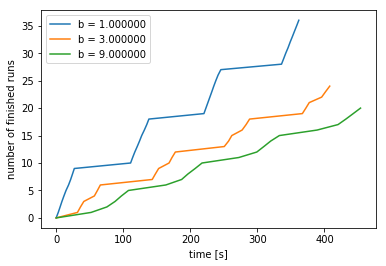

In [17]:
# START TODO ##################
hpvis.finished_runs_over_time(all_runs)
pass

Evaluating configurations on lower budgets doesn't make sense - even if they are faster - if the performance ranking isn't consistent from low to high budget. This means, that the loss rankings for configurations should correlate. In simplified terms: The best configuration after one epoch should also be the best after nine epochs, the second best should stay the second best and so on.

**Task:** Plot correlations of rankings across budgets. Are the correlations high enough?

**Answer:**  
Yes, the correlations are high enough, i.e. the absolute value of Spearman's correlation coefficient is greater than 0.5 in all cases.

19:52:49 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/borna/opt/anaconda3/envs/dl4ad/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


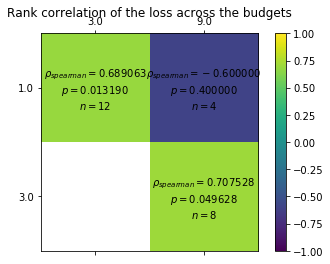

In [18]:
# START TODO ##################
hpvis.correlation_across_budgets(result)
pass

We usually assume, that training on a higher budget (number of epochs) and sampling more configurations can lead to better results. Let's check this.

**Task:** Plot the losses over time. Do our assumptions hold true? Why?

**Answer:**  
They seem to hold true because the more budget (more epochs; more training time) we give to a certain configuration, the more we allow it to get closer to the local optimum.

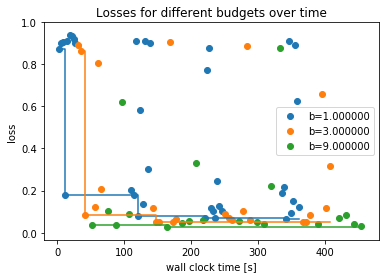

In [19]:
# START TODO ##################
hpvis.losses_over_time(all_runs)
pass

Remember that BOHB uses a model after some time to improve the configuation sampling. We can check, if the BO-sampled configurations work better than the random-sampled.

**Task:** Plot loss histograms for all budgets only with BO-sampled and only with random-sampled configurations (6 histograms). Is the BO-sampling useful?

**Answer:**  
BO-sampling of configurations is much more useful than the random-sampling. That is clearly visible from the plotted histograms: already for the budget of 1, most of the sampled configurations have the loss lower than 0.5. Later on, for the budget of 3 and especially 9, most of the sampled configurations are closer to the loss of 0 (i.e. we have informed sampling).

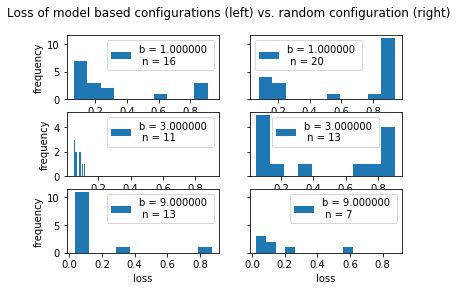

19:54:48 WORKER: shutting down now!


In [20]:
# START TODO ##################
hpvis.performance_histogram_model_vs_random(all_runs, id2conf)
pass

### Your Feedback on Exercise 6.2

- Time spent: 3 h
- Useful: very!
- Major problems: none

It was very cool to see how ConfigSpace works in combination with Bayesian optimization. Again, as we said in the previous feedback, we used BOHB in Machine Learning course and it was nice to use it one more time. The new thing for us were various visualizations such as rank correlation and histogram visualizations. Really cool tool and we hope to use it more often in practice.